### Imports

In [1]:

import networkx as nx
import numpy as np
import random, math
import graphviz
import functools, collections, operator

import os
import time

#import kaleido

import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import plotly.graph_objects as go
from pyvis.network import Network
from networkx.drawing.nx_agraph import graphviz_layout
import plotly.express as px
from plotly._subplots import make_subplots
import plotly


# import models
from classes.jackson_model import JacksonSimulationV2
from classes.network_drawing import plotly_sim_drawing


In [8]:

# showcases
showcase_sim_no_bias = JacksonSimulationV2(0, 100, 10, 1, 10, 1, 0.5, biased=False, rho=1, epsilon=1)
showcase_sim_expo = JacksonSimulationV2(0, 100, 10, 1, 10, 1, 0.5, biased=True, rho=1, epsilon=1.5)
showcase_sim_fb = JacksonSimulationV2(0, 100, 10, 1, 10, 1, 0.5, biased=True, rho=1.5, epsilon=1)
showcase_sim_expo_fb = JacksonSimulationV2(0, 100, 10, 1, 10, 1, 0.5, biased=True, rho=1.5, epsilon=1.5)

showcase_sims = [showcase_sim_no_bias, showcase_sim_expo, showcase_sim_fb, showcase_sim_expo_fb]

showcase_plots = [plotly_sim_drawing.plotly_draw(plotly_sim_drawing(), showcase_sim, layout='spring', draw_largest_CC=True, title=None) for showcase_sim in showcase_sims]





In [12]:

showcase_plots[0]


# Testing overall characteristics

## General social network characteristics

Need to test: 

* Short APL (order of log(n))
* Larger clustering coefs than random
* Fat degree tails
* Positive assortativity
* Negative clustering-neighbour-degree correlation




In [10]:

n_sims = 1


val_dict = {'APL': [], 'Clustering': [], 'Assortativity': [], 'Degree-neighbour-clustering': [], 'Degree-list': []}

for i in range(n_sims):
    sim = JacksonSimulationV2(0, 100, 5, 1, 5, 1, 0.5, False, 1)
    graph = sim.graph_history[-1]
    return_dict = sim.helper_functions().graph_social_network_chars(graph, summarise=False)

    for key in list(val_dict.keys()):
        val_dict[key].append(return_dict[key])


degree_list = list(np.concatenate(val_dict['Degree-list']))
del val_dict['Degree-list']

val_df = pd.DataFrame(val_dict)


Seems to work alright: positive CND correlation probably driven by relativley low clustering overall, consistent with their findings for small number of nodes.

## Stuff to do with SES

### Rho effect on HSES assortativity

In [2]:

# initial nodes and time
initial_n = 0
T = 100

p = 0.25

# parent nodes and prob
m = 4
pm_o = p

# parent neighbours and prob
n = 16
pn_o = p

rho = 3

# p high SES
p_SES_high = 0.5

rho_list = np.arange(0.25, 5, 0.05)
rho_list = [rho_val for rho_val in rho_list]
test_sims = [JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, rho=rho_val) for rho_val in rho_list]


SES_assortativity_list = [nx.assortativity.attribute_assortativity_coefficient(sim.graph_history[-1], 'SES_High') for sim in test_sims]


#plt.plot(rho_list, SES_assortativity_list)






In [3]:

df_rho_SES_ass = pd.DataFrame(np.transpose([rho_list, SES_assortativity_list]), columns=['Rho', 'SES Assortativity'])

rho_ass = px.line(df_rho_SES_ass, x='Rho', y='SES Assortativity')

rho_ass.update_layout(
    title = None, 
    font=dict(size = 18),
    xaxis_title = 'Rho', 
    yaxis_title = 'SES Assortativity',
    width = 500, height = 500,
    showlegend = True, 
    legend=dict(x=0.75,y=1),
    legend_title_text = '',
    xaxis_range = [0,5],
    yaxis_range = [-1,1],
    margin=dict(b=5,l=5,r=5,t=5),
    xaxis = dict(showgrid = False, showline = True, linecolor = 'rgb(0,0,0)', linewidth = 2), 
    yaxis = dict(showgrid = False, showline = True, linecolor = 'rgb(0,0,0)', linewidth = 2),
    plot_bgcolor='rgba(0,0,0,0)')

rho_ass.data[0].line.color = "rgb(250, 20, 250)"
rho_ass.add_hline(y=0, line_width=1, annotation_text = 'Equal share')
rho_ass.add_vline(x=1, line_width=1, annotation_text = 'rho=1: no bias')


### Rho effect on share HSES

In [282]:

# initial nodes and time
initial_n = 0
T = 100

p = 0.25

# parent nodes and prob
m = 4
pm_o = p

# parent neighbours and prob
n = 16
pn_o = p

rho = 3

# p high SES
p_SES_high = 0.5

# run several simulations
rho_list = np.arange(0.25, 5, 0.05)
n_per_rho = 10

test_sims = [[JacksonSimulationV2(initial_n, T, m, pm_o, n, pn_o, p_SES_high, biased=True, rho=rho_val) for i in range(n_per_rho)] for rho_val in rho_list]





In [283]:

# 
H_shares = [np.transpose([new_sim.helper_functions().average_neighbour_type_per_SES(test_sims[i][j].graph_history[-1]) for j in range(n_per_rho)]) for i in range(len(rho_list))]
avg_H_shares = np.transpose(np.average(H_shares, axis=2))
df_avg_H_shares = pd.DataFrame(np.transpose(avg_H_shares), columns=['High SES', 'Low SES'])
df_avg_H_shares['Rho_val'] = rho_list

rho_lines = px.line(df_avg_H_shares, x='Rho_val', y=['High SES', 'Low SES'])

rho_lines.update_layout(
    title = None, 
    font=dict(size = 18),
    xaxis_title = 'Rho', 
    yaxis_title = 'Share of HSES friends',
    width = 500, height = 500,
    showlegend = True, 
    legend=dict(x=0.75,y=1),
    legend_title_text = '',
    xaxis_range = [0.025,5],
    yaxis_range = [0,1],
    margin=dict(b=5,l=5,r=5,t=5),
    xaxis = dict(showgrid = False, showline = True, linecolor = 'rgb(0,0,0)', linewidth = 2), 
    yaxis = dict(showgrid = False, showline = True, linecolor = 'rgb(0,0,0)', linewidth = 2),
    plot_bgcolor='rgba(0,0,0,0)')

rho_lines.data[0].line.color = "rgb(200, 20, 0)"
rho_lines.data[1].line.color = "rgb(0, 20, 200)"
rho_lines.add_hline(y=0.5, line_width=1, annotation_text = 'Equal share')
rho_lines.add_vline(x=1, line_width=1, annotation_text = 'rho=1: no bias')

rho_lines



### Varying p

Varying p

c:\Programming\Python\lib\site-packages\networkx\algorithms\assortativity\correlation.py:278: RuntimeWarning:

invalid value encountered in double_scalars



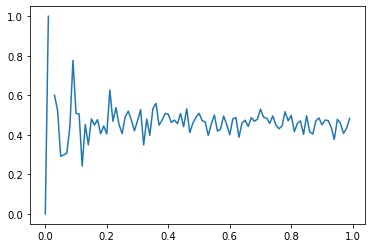

In [152]:

# initial nodes and time
initial_n = 0
T = 100

p = 0.25

# parent nodes and prob
m = 4
pm_o = p

# parent neighbours and prob
n = 16
pn_o = p

rho = 3

# p high SES
p_SES_high = 0.5

p_list = np.arange(0, 1, 0.01)
test_sims = [JacksonSimulationV2(initial_n, T, m, pm_o=p, n=n, pn_o=p, p_SES_high=p_SES_high, biased=True, rho=3) for p in p_list]


SES_assortativity_list = [nx.assortativity.attribute_assortativity_coefficient(sim.graph_history[-1], 'SES_High') for sim in test_sims]


plt.plot(p_list, SES_assortativity_list)
